# Medical mask dataset downloaded at
https://humansintheloop.org/resources/datasets/mask-dataset-download

In [1]:
import json
import pandas as pd
from glob import glob
import cv2
import ast
import os
import sys
from tqdm.notebook import tqdm
import shutil 
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style("darkgrid")
import numpy as np

# Setup stuff
PATH = "C:/Users/JK/Desktop/datasets/Medical mask/"
image_path = r"C:/Users/JK/Desktop/datasets/Medical mask/Medical Mask/images/"
yolo_dataset_path = "C:/Users/JK/Desktop/datasets/mask_dataset_yolo/"

SAVE_IMAGES = False
UPLOAD_TO_KAGGLE = False

# Add utils path
sys.path.append('../')
from project_utils import helpers as H

H.expand_jupyter_screen()

# Initial reformatting - .json to .csv

In [15]:
reformat = False # <-- Only need to do this ones
if reformat:
    annotations_path = r"C:\Users\JK\Desktop\datasets\Medical mask\Medical Mask\annotations/"
    annotations_dicts = [H.read_json(p)for p in glob(annotations_path + "/*")]

    meta_data = H.read_json(PATH + "meta.json")
    meta_data = pd.DataFrame(meta_data["classes"])
    del meta_data["geometry_config"]
    meta_data.to_csv(PATH + "meta_data.csv", index=False)

    for i, d in enumerate(annotations_dicts):
        if i == 0:
            df_anno = pd.DataFrame(annotations_dicts[0])
        else:
            df_anno = df_anno.append(pd.DataFrame(annotations_dicts[i])).reset_index(drop=True)

    df_anno["bb"] = None
    df_anno["label"] = None

    for index, item in df_anno.iterrows():
        d = item.Annotations
        df_anno.loc[index, ["label"]] = d["classname"]
        df_anno.loc[index, ["bb"]] = str(d["BoundingBox"])

    del df_anno["Annotations"]

    df_anno = df_anno.rename(columns={"FileName":"file_name", "NumOfAnno": "#anno"})
    df_anno.to_csv(PATH+"annotations.csv", index=False)

    del df_anno, meta_data

# Load data

In [16]:
df_anno = pd.read_csv(PATH + "annotations.csv")
df_meta = pd.read_csv(PATH + "meta_data.csv")

# Just pandas being pandas. Simplest way i could find to store it as an actual list of ints
# as opposed to '[1, 2, ...]' or ['1', '2' ...] or some other shenanigans..
# For whatever reason I'm not allowerd to do this before saving it i.e. its become a str when reloaded
for i in tqdm(df_anno.index):
    df_anno.loc[i, ["bb"]] = df_anno.loc[i, ["bb"]].apply(ast.literal_eval)

display(df_meta.head())
df_anno.head()

  0%|          | 0/23554 [00:00<?, ?it/s]

title      shape    color geometry_config
0               hijab_niqab  rectangle  #2D7B53              {}
1             mask_colorful  rectangle  #ADCE88              {}
2             mask_surgical  rectangle  #319051              {}
3              face_no_mask  rectangle  #50E3C2              {}
4  face_with_mask_incorrect  rectangle  #D0021B              {}

file_name  #anno                     bb                label
0  0001.jpg      3   [438, 140, 822, 583]  face_other_covering
1  0001.jpg      3    [366, 11, 825, 280]                  hat
2  0001.jpg      3   [405, 125, 899, 610]                 hood
3  0002.png      1     [332, 9, 590, 371]         face_no_mask
4  0003.jpg      3  [1222, 9, 2645, 1746]       face_with_mask

# Helpers

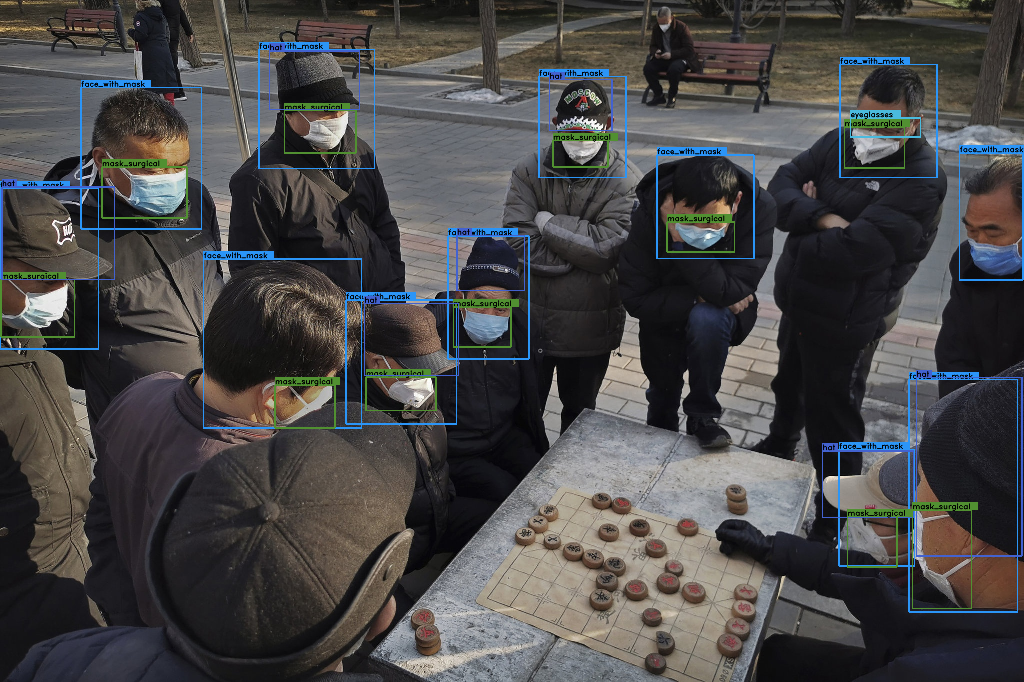

In [17]:
def get_color(class_name):
    return df_meta[ df_meta["title"] == class_name]["color"].iloc[0]


def draw_bb(file_name:str):
    img = cv2.imread(image_path + file_name)
    
    for _, anno in df_anno[ df_anno["file_name"] == file_name ].iterrows():
        x1, y1, x2, y2 = anno["bb"]
        color = color=get_color(anno["label"])
        H.cv2_draw_bounding_boxes(img, p1=(x1, y1), p2=(x2, y2), label=anno["label"],
                                  conf=None, color=color, text_color=(0,0,0))

    return img

def show_random_bb_images(label, amount, resize_factor=0.5):
    for _ in range(amount):
        sample_name = df_anno[ df_anno["label"] == label].sample().file_name.values[0]
        print(sample_name)
        show_image(sample_name, resize_factor=resize_factor)


def show_image(file_name:str, resize_factor:float = 1.0, draw_annotations:bool = True):
    img = draw_bb(file_name)
    if SAVE_IMAGES: cv2.imwrite("mask_dataset_example.png", img)
    H.cv2_show_image(img, resize_factor=resize_factor)
    
# Testing
sample_name = "0007.jpg"
show_image(sample_name, resize_factor=0.5);

# Cleaning the data
First of all, what do we want here? For instance, whether or not a person is wearing sun glasses or a niqab is perhaps not that interesting for the problem at hand, so I'll remove these categories.

In [18]:
if len(df_meta) > 15: # <-- Only clean the data ones
    of_interest = [1,2,3,4,5,6,9]
    labels_of_interest = list(df_meta.iloc[of_interest].title.values)
    df_meta = df_meta.iloc[of_interest].reset_index(drop=True)
df_meta

if len(df_anno) > 20_000: # <-- Only clean the data ones
    keep = []
    for index, item in df_anno.iterrows():
        if item.label in labels_of_interest:
            keep.append(index)        
    df_anno = df_anno.iloc[keep].reset_index(drop=True)
    
df_anno.head()

file_name  #anno                       bb                label
0  0001.jpg      3     [438, 140, 822, 583]  face_other_covering
1  0002.png      1       [332, 9, 590, 371]         face_no_mask
2  0003.jpg      3    [1222, 9, 2645, 1746]       face_with_mask
3  0003.jpg      3  [1261, 801, 2347, 1735]        mask_surgical
4  0004.jpg      2     [606, 114, 918, 460]       face_with_mask

## Huge class imbalance is an issuse
Think it would be wises to collapse some of the classes and try to restore some sort of class balance.

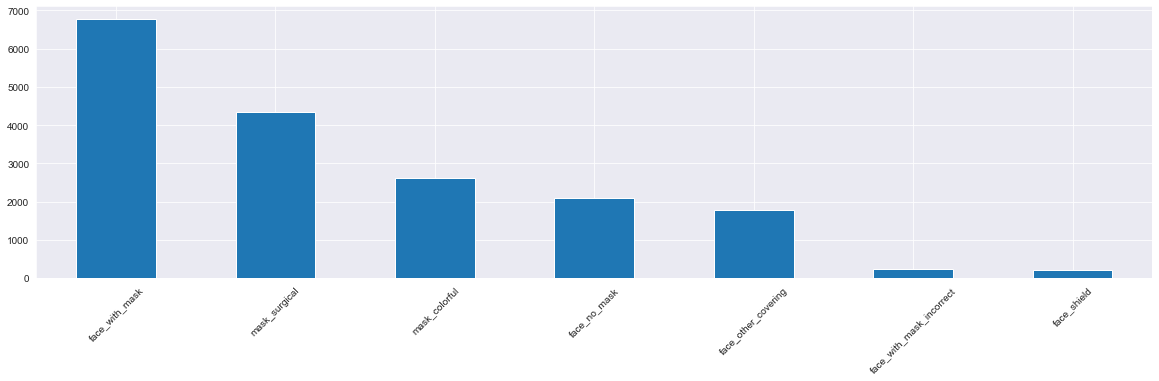

In [19]:
df_anno["label"].value_counts().plot.bar(figsize=(20,5), rot=45);
if SAVE_IMAGES:
    H.save_plt_plot("mask_dataset_class_dist1.png")

### Closer look at: face_other_covering
I see no reason to keep the `face_other_covering` category since it does little to prevent the spread of covid19 which is why I'm going to merge it with `face_no_mask`. <br>

In [20]:
SAVE_IMAGES = True

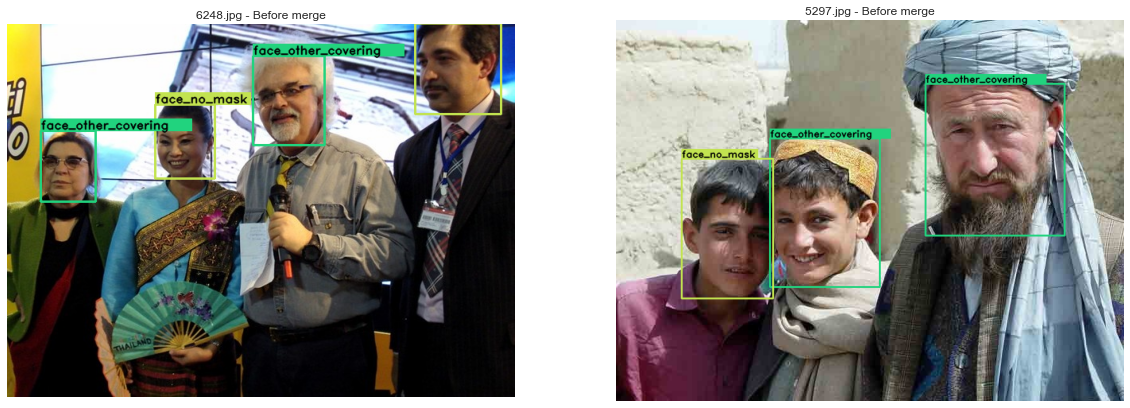

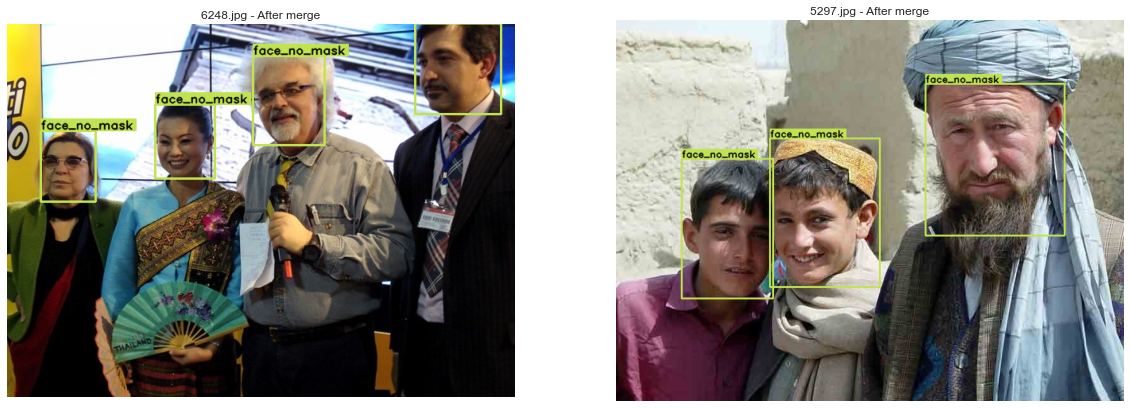

In [21]:
other_covering_examples = ["6248.jpg", "5297.jpg"] # found with `show_random_bb_images`

fig, axs = plt.subplots(1,2, figsize=(20,15))
for i, ax in enumerate(axs):
    file_name = other_covering_examples[i]
    bb_image = draw_bb(file_name)[:, :, ::-1] # [:, :, ::-1] --> BGR to RGB
    ax.imshow(bb_image)
    ax.set_title(file_name + " - Before merge")
    ax.axis("off")

if SAVE_IMAGES:
    H.save_plt_plot("mask_dataset_merge_classes1a.png")
    
# Merge
df_anno.loc[df_anno["label"] == "face_other_covering", "label"] = "face_no_mask"

# Clean df_meta
df_meta = df_meta.drop( df_meta[df_meta["title"] == "face_other_covering"].index[0]).reset_index(drop=True)

fig, axs = plt.subplots(1,2, figsize=(20,15))
for i, ax in enumerate(axs):
    file_name = other_covering_examples[i]
    bb_image = draw_bb(file_name)[:, :, ::-1] # [:, :, ::-1] --> BGR to RGB
    ax.imshow(bb_image)
    ax.set_title(file_name + " - After merge")
    ax.axis("off")

if SAVE_IMAGES:
    H.save_plt_plot("mask_dataset_merge_classes1b.png")

## Closer look at: mask_colorful, face_sheild and mask_surgical
`mask_colorful` and `face_sheild` seems as valid to wear as `mask_surgical`, which is why I would like to merge all 3 into `valid_mask`.
The problem is that the `face_shield` class is kinda difficult to deal with. As you can see below, a face without an actual mask is labeled as `face_no_mask` which kinda defeat the purpuse of the class `face_with_mask` being synonymous with `ALL_GOOD`. Secondly the vast majority of the faces wearing a `face_shield` also wears a mask which going to be a problem for YOLO. All in all, the relatively small amount of labeled `face_shield` samples and the troubles associated with it, made be think it would be best to simple remove the label entirely. This decision is admittely not optimial, but neither would it be to do nothing.

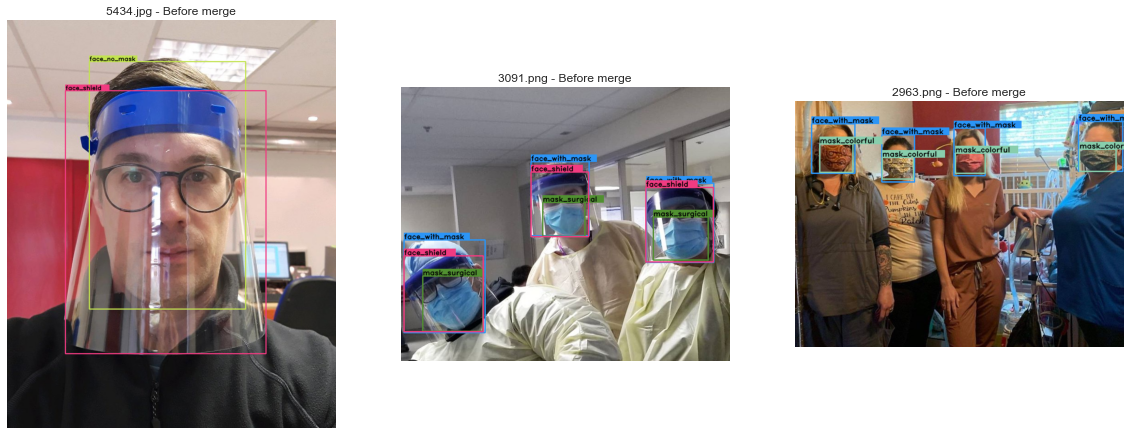

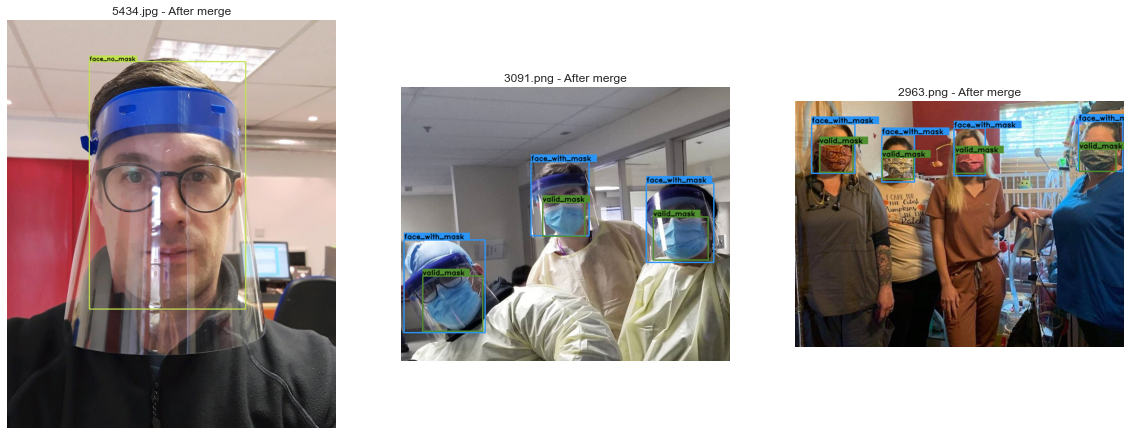

In [22]:
other_covering_examples = ["5434.jpg", "3091.png", "2963.png"] # found with `show_random_bb_images`

fig, axs = plt.subplots(1,3, figsize=(20,15))
for i, ax in enumerate(axs):
    file_name = other_covering_examples[i]
    bb_image = draw_bb(file_name)[:, :, ::-1] # [:, :, ::-1] --> BGR to RGB
    ax.imshow(bb_image)
    ax.set_title(file_name + " - Before merge")
    ax.axis("off")

if SAVE_IMAGES:
    H.save_plt_plot("mask_dataset_merge_classes2a.png")
    
# Remove face shield annotations
annotations_with_shield = df_anno[df_anno["label"] == "face_shield"].index
df_anno = df_anno.drop(annotations_with_shield)

# Merge `mask_surgical` and `mask_colorful` in `valid_mask`. And add color to `valid_mask`.
df_anno.loc[df_anno["label"] == "mask_colorful", "label"] = "valid_mask"
df_anno.loc[df_anno["label"] == "mask_surgical", "label"] = "valid_mask"

## Clean up
# Pandas being pandas, again. All i wanted was to delete the row dynamically, but...
index_to_remove = [df_meta[df_meta["title"] == "face_shield"].index[0], df_meta[df_meta["title"] == "mask_colorful"].index[0]]
df_meta = df_meta.drop(index_to_remove).reset_index(drop=True)
df_meta.loc[df_meta.title == "mask_surgical", "title"] = "valid_mask"

fig, axs = plt.subplots(1,3, figsize=(20,15))
for i, ax in enumerate(axs):
    file_name = other_covering_examples[i]
    bb_image = draw_bb(file_name)[:, :, ::-1] # [:, :, ::-1] --> BGR to RGB
    ax.imshow(bb_image)
    ax.set_title(file_name + " - After merge")
    ax.axis("off")
    

if SAVE_IMAGES:
    H.save_plt_plot("mask_dataset_merge_classes2b.png")

## Closer look at face_with_mask_incorrect
For the use case I intend i.e. check if a person has a mask, It would be nice to check if the mask is applied correctly, but its not super important. This along with the low number of samples for this category, make me think the best action is to merge `face_with_mask_incorrect` with `face_with_mask`.

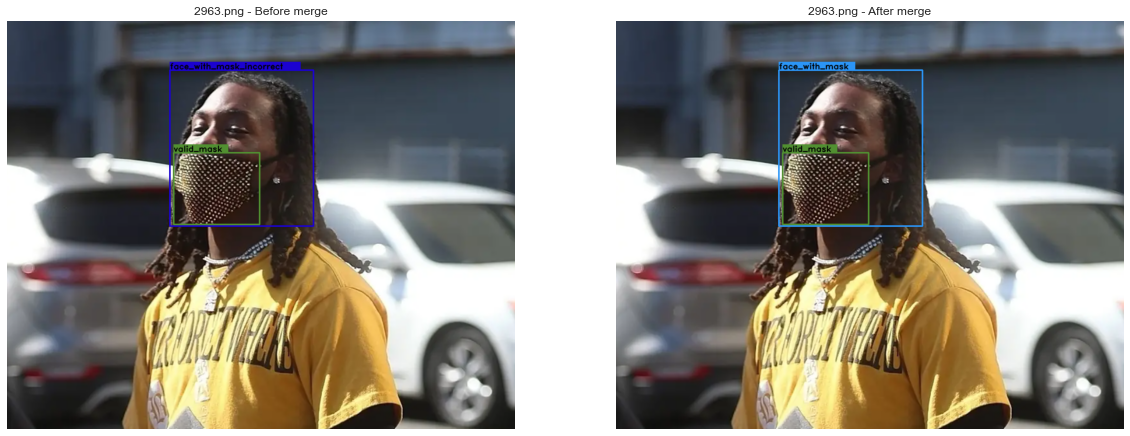

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,15))

bb_image = draw_bb("2922.png")[:, :, ::-1] # [:, :, ::-1] --> BGR to RGB
ax1.imshow(bb_image)
ax1.set_title(file_name + " - Before merge")
ax1.axis("off")

# Merge face_with_mask_incorrect and face_with_mask
df_anno.loc[df_anno["label"] == "face_with_mask_incorrect", "label"] = "face_with_mask"

# Clean df_meta
df_meta = df_meta.drop( df_meta[df_meta["title"] == "face_with_mask_incorrect"].index[0]).reset_index(drop=True)

bb_image = draw_bb("2922.png")[:, :, ::-1] # [:, :, ::-1] --> BGR to RGB
ax2.imshow(bb_image)
ax2.set_title(file_name + " - After merge")
ax2.axis("off");

## Final label distribution
`face_no_mask` is still off by ~50%, but I think it's going to be okay. Might have to use label smoothing or some other technique to deal with the reamaining imbalance, but that's not something I'm gonna worry about at this stage.

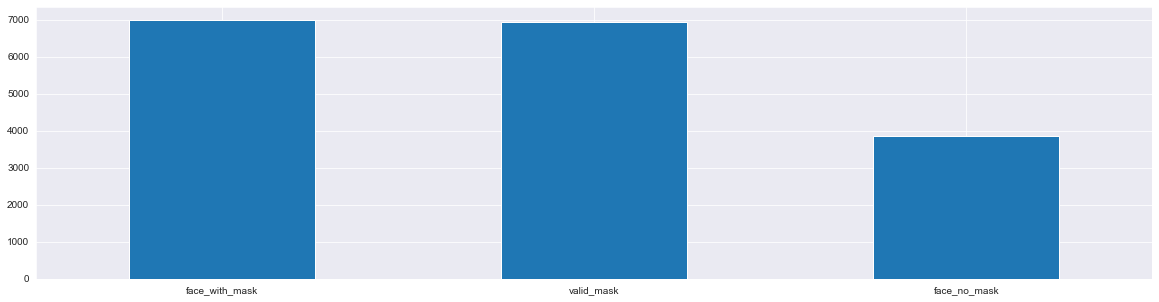

In [11]:
df_anno["label"].value_counts().plot.bar(figsize=(20,5), rot=0);
if SAVE_IMAGES:
    H.save_plt_plot("mask_dataset_final_class_dist.png")


# Manually stratified train-validation split
Gonna do this manually because I think it's easier in this particular case. I've plotted the distribution of both the validation and the training dataset. This was done to ensure the datasplit hadn't introduced to much of a class imbalance (which it clearly hadn't, if anything, the plot/distriution of the validation dataset seems a bit better). 

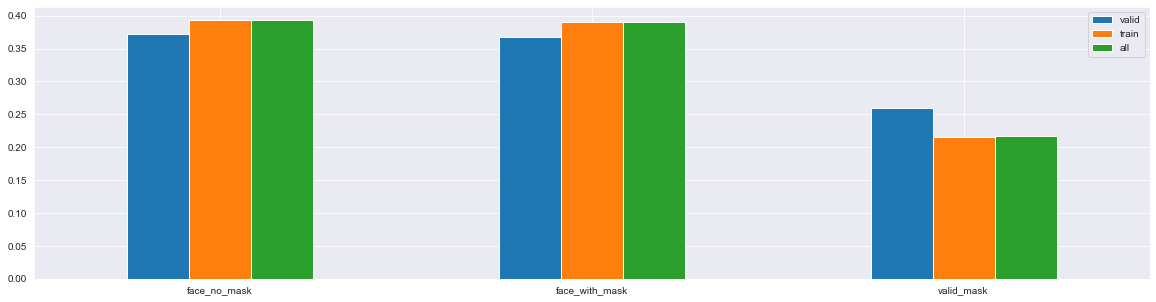

In [12]:
# Randomly select 60 images from each of the 3 classes 
df_anno = df_anno.reset_index(drop=True)
number_of_samples_per_label = 60
file_names_for_validation = []
np.random.seed(0)

for label in ["face_no_mask", "face_with_mask", "valid_mask"]:
    candidates = df_anno[df_anno["label"] == label]["file_name"].unique()
    for n in range(number_of_samples_per_label):
        pick = np.random.choice(candidates, 1)
        if pick not in file_names_for_validation:
            file_names_for_validation.append(pick[0])
indexs = []
for name in file_names_for_validation:
    indexs += list(df_anno[df_anno["file_name"] == name].index)


# Make actual split
all_index = df_anno.index.to_numpy()
valid_index = df_anno.iloc[indexs].index.to_numpy()
train_index = np.setdiff1d(all_index, valid_index)
df_train = df_anno.iloc[train_index].reset_index(drop=True)
df_valid = df_anno.iloc[valid_index].reset_index(drop=True)


#Display label distrubtion (in percentage)
valid_label_counts = df_anno.iloc[valid_index].label.value_counts()
valid_normalized = (valid_label_counts / sum(valid_label_counts)).to_numpy()

train_label_counts = df_anno.iloc[train_index].label.value_counts()
train_normalized = (train_label_counts / sum(train_label_counts)).to_numpy()

all_label_counts = df_anno.label.value_counts()
all_normalized = (all_label_counts / sum(all_label_counts)).to_numpy()

pd.DataFrame({"valid":valid_normalized, "train":train_normalized, "all":all_normalized}, 
             index=df_anno.label.unique()).plot.bar(rot=0, figsize=(20,5));

if SAVE_IMAGES:
    H.save_plt_plot("mask_dataset_train_valid.png")

# Yolo formatting - Make and wriite YOLO-format to file
Yolo expects the bounding boxes to be in the format `[class_name, center_x, center_y, width, height]`. 
<br>Example of 1 image with 2 annotations:

    0 0.3811349693251534 0.6422121896162528 0.16717791411042945 0.17832957110609482
    7 0.8021390374331551 0.8090349075975359 0.232620320855615 0.26283367556468173

Each image have its own `.txt` file with BB-infomation formatted as above.

## Creating YOLO folder structure and .yaml config file

In [ ]:
# Setup YOLO folder structure
os.mkdir(yolo_dataset_path + "images")
os.mkdir(yolo_dataset_path + "/images/train")
os.mkdir(yolo_dataset_path + "/images/valid")

os.mkdir(yolo_dataset_path + "labels")
os.mkdir(yolo_dataset_path + "/labels/train")
os.mkdir(yolo_dataset_path + "/labels/valid")

# Make .yaml config file
string_to_yaml_file = """\
# Heively modified version of humansintheloop's Medical mask dataset.
# All credit goes to them.
# https://humansintheloop.org/resources/datasets/mask-dataset-download/

# paths
train: ../input/mask-detection-dataset/images/train
val: ../input/mask-detection-dataset/images/train

# number of classes
nc: 3

# class names
names: ['valid_mask', 'face_no_mask', 'face_with_mask']\
"""

H.write_to_file(yolo_dataset_path+"/mask_detection_dataset_kaggle.yaml", string_to_yaml_file, only_txt=False)

## Create annotations and move images

In [ ]:
# # Yolo expect label to be an int
label_to_int = {df_meta.iloc[i]["title"]:i for i in range(len(df_meta))}

for df, dataset_type in [[df_train, "train"], [df_valid, "valid"]]:
    print(f"{dataset_type} dataset is being made...")
    for file_name in tqdm(df["file_name"].unique()):
        
        # Copy image
        from_path = f"{image_path}{file_name}"
        to_path = f"{yolo_dataset_path}/images/{dataset_type}/{file_name}"
        shutil.copyfile( from_path, to_path)
        
        # Extract bb-coordinates and convert them to YOLO-format
        width, height = H.get_image_size(image_path + file_name)
        to_file_string = ""
        for index, item in df[df["file_name"] == file_name].iterrows():
            string = H.normal_bb_coordinates_to_yolo_format(item["bb"], width, height, label_to_int[item["label"]])
            to_file_string += string + "\n"
        to_file_string = to_file_string[:-1] # delete the last "\n"

        # Create annotations
        file_name_txt = file_name[:-len(H.extract_file_extension(file_name))] + ".txt"
        annotation_path = f"{yolo_dataset_path}/labels/{dataset_type}/{file_name_txt}"
        H.write_to_file( annotation_path, to_file_string)
        
# Saving dataframes for good measure
df_train.to_csv(yolo_dataset_path + "df_train.csv", index=False)
df_valid.to_csv(yolo_dataset_path + "df_valid.csv", index=False)

# Sending dataset to kaggle.
My graphics card dosn't have enough VRAM, so gonna train the YOLO-model on kaggle instead.

In [ ]:
if UPLOAD_TO_KAGGLE:
    project_display_name = "Mask Detection Dataset"
    project_folder_name = "mask-detection-dataset"
    upload_folder_path = yolo_dataset_path

    # Checks. Kaggle handle som mistakes after the upload is complete, which is kinda
    # painful when the dataset is as large as this, because you have to start all over
    assert project_folder_name.find("_") == -1, "Kaggle dosn't accept underscores"
    assert not os.path.exists("./dataset-metadata.json"), "This should have been deleted"

    # Make the json config file kaggle expects
    write_string=['{', 
                  f'  "title": "{project_display_name}",', 
                  f'  "id": "jakobi/{project_folder_name}",', 
                   '  "licenses": [{"name": "CC0-1.0"}]',
                 '}']

    file = open("./dataset-metadata.json", mode="a")
    [print(s, file=file, end="") for s in write_string]
    file.close()

    # Zip the file 
    shutil.make_archive(f"./{project_folder_name}", 'zip', upload_folder_path)

    # Upload dataset to kaggle
    os.system(f"kaggle datasets create -p ./")

    # Clean up
    os.remove("./dataset-metadata.json")
    os.remove(f"./{project_folder_name}.zip")